### W207 Final Project
### Spring 2020
### Kaggle Challenge: Facial Keypoints Detection
### Part 1 of 3
### Sang-hyeb Lee, Haerang Lee, Julia Ying

# 1. Download from Kaggle and mount Google Drive

the following code assumes there is a folder "facial_recognition" inside the mounted GoogleDrive, and that inside that folder, there are is a subfolder "resources"

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# upload the kaggle json token
uploaded = files.upload()

# download data
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/*
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list
!kaggle competitions download -c facial-keypoints-detection

# mount google drive
# the following code assumes there is a folder "facial_recognition" inside the GoogleDrive
# and that inside that folder, there is a subfolder "resources"
from google.colab import drive
drive.mount('/content/drive')


Saving kaggle.json to kaggle.json
/root/.kaggle/kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-11 13:32:24          52426  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           3824  
praveengovi/coronahack-chest-xraydataset                       CoronaHack -Chest X-Ray-Dataset                       1GB  2020-03-20 01:26:40            526  
katerpillar/meteonet                                           MeteoNet North-West France                           11GB  2020-04-16 08:35:45    

# 2. Exploratory Data Analysis

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# load data
original_train_df = pd.read_csv("training.zip")
original_test_df = pd.read_csv("test.zip")

In [0]:
# EDA on missing data
print(original_train_df.info())

# find out number of number of rows with missing values
print(f"Total number of rows: {original_train_df.shape[0]}")
print(f"Total number of rows with NaN : {original_train_df.shape[0] - original_train_df.dropna().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

<Figure size 1440x1440 with 0 Axes>

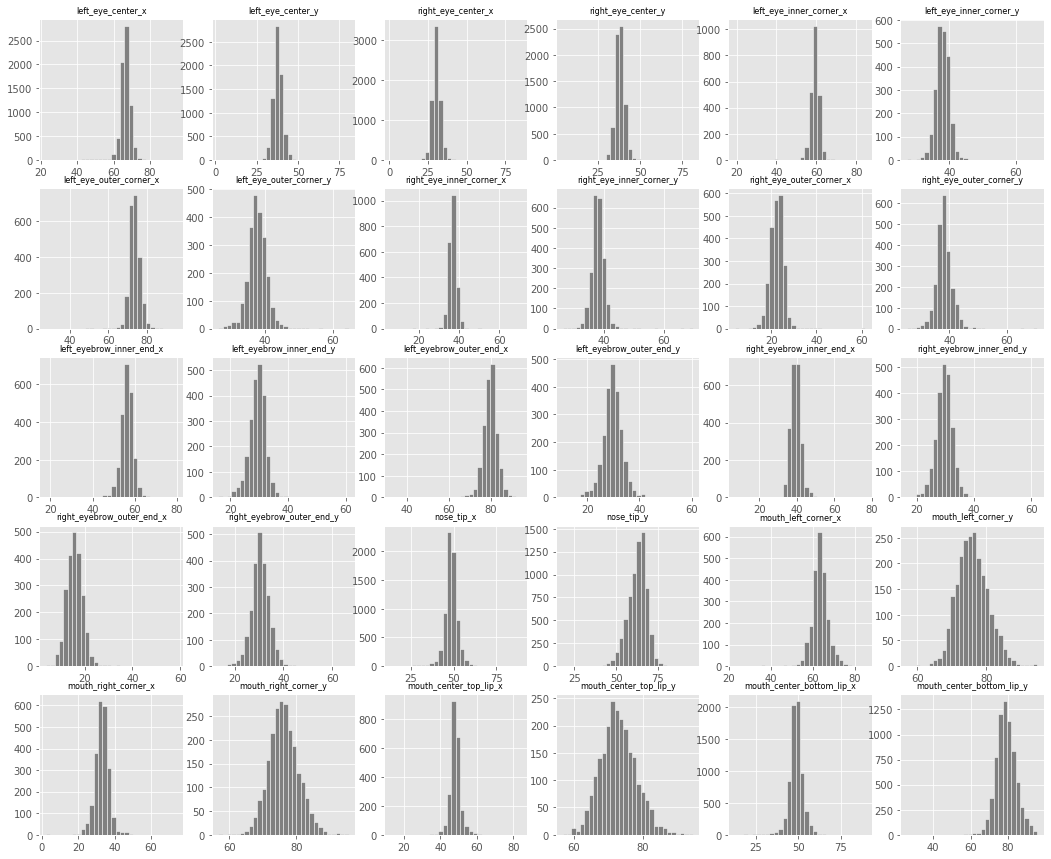

In [0]:
# histogram analysis of the training data's point of interest coordinates
plt.figure( figsize = (20, 20))

fig, ax = plt.subplots(5,6, figsize=(18,15)) 
for c in range(30):  
    curr_column = original_train_df.columns[c] 
    i = int(np.floor(c/6))
    j = int(np.mod(c,6))

    original_train_df[curr_column].hist(bins = 30, color = "gray", edgecolor = "white", ax=ax[i, j])
    ax[i, j].set_title(curr_column, fontdict = {'fontsize': 8})

plt.show()

There are 31 columns in this dataset. Each column except the last one represents a facial feature point as a float in given diemsion. Last column contains image dataset as a string. There are 4909 rows with missing values.

It looks like there are two groups of features in the dataset. First group of features have the number of rows between 7016 ~ 7049. These are centers of left and right eye, mouth upper and lower tip, and nose tip. Second group of features have the number of rows between 2225 ~ 2275. These are all corner key points.

Values of each key point are roughly normally distributed. Interestingly, the Y coordinates for each key point have higher variance than x coordinates for the same point. This is especially true for the mouth centers and corner, probably because smiling changes the height of the mouth corners, and opening and closing the mouth changes the height of lips centers.


# 3. Create inputs (X) for training, development, and test set

In [0]:
# the training data isn't missing data at random, the earlier rows have all the data points, 
# the later rows have some data missing. shuffling this dataframe so the dev set
# does not end up with only rows with missing data
# shuffled_train_df = original_train_df.sample(frac=1).reset_index(drop = True)
shuffled_train_df = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/shuffled_train_df.pkl", "rb" ) )

# create inputs (X) for train, dev, test. Each row is pixel grayscale value for one image.

# get the image data from training csv, convert into ndarray, reshape into the shape the CNN requires)
train_input = [x.split(' ') for x in shuffled_train_df['Image'].tolist()]
train_input = np.asarray(train_input).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)

# divide input data up into train and dev set
X_train = train_input[:6000]
X_dev = train_input[6000:]

X_test = [x.split(' ') for x in original_test_df['Image'].tolist()]
X_test = np.asarray(X_test).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)

# pickle them
pickle.dump( X_train, open( "/content/drive/My Drive/facial_recognition/resources/train_img.pkl", "wb" ) )

pickle.dump( X_dev, open( "/content/drive/My Drive/facial_recognition/resources/dev_img.pkl", "wb" ) )

pickle.dump( X_test, open( "/content/drive/My Drive/facial_recognition/resources/test_img.pkl", "wb" ) )

pickle.dump( shuffled_train_df, open( "/content/drive/My Drive/facial_recognition/resources/shuffled_train_df.pkl", "wb" ) )

# 4. Create unmodified outputs (Y) for training and development set

In [0]:
# save a copy of the original output with the NaNs, just in case
original_output = shuffled_train_df.drop('Image', axis = 1).to_numpy()
Y_train_original = original_output[:6000]
Y_dev_original = original_output[6000:]

with open('/content/drive/My Drive/facial_recognition/resources/train_kp_original.pkl', 'wb') as f: 
    pickle.dump(Y_train_original, f)

with open('/content/drive/My Drive/facial_recognition/resources/dev_kp_original.pkl', 'wb') as f: 
    pickle.dump(Y_dev_original, f)

# 5. Create outputs (Y), filling missing values

In [0]:
# helper function to plot 9 pictures and their respective point of interest, 
# shows which points were in original dataset and which points were extrapolated

def plot_images(img_array, kp_actual, kp_extrapolated):
  # kp_actual is the original data points with missing data points
  # kp_extrapolated is the key point coordinates with missing values filled

  fig, ax = plt.subplots(3,3, figsize=(15,15))
  plt.setp(ax, xticks=(), yticks=())  

  # each row in img_array is a picture
  for row in range(9):   

      image = img_array[row,:].reshape(96, 96)
      curr_kp_actual = kp_actual[row,:]
      curr_kp_extrapolated = kp_extrapolated[row,:]

      # plot image at the appropriate subplot coordinate
      i = int(np.floor(row/3))
      j = int(np.mod(row,3))
      ax[i,j].imshow(image, cmap="gray")

      # create tuples for each key point, each tuple is a pair of x, y
      kp_actual_zipped = list(zip(curr_kp_actual[::2], curr_kp_actual[1::2]))
      kp_extrapolated_zipped = list(zip(curr_kp_extrapolated[::2], curr_kp_extrapolated[1::2]))

      # remove the actual data points from the extrapolated data points
      kp_extrapolated_zipped = list(set(kp_extrapolated_zipped) - set(kp_actual_zipped))
      
      # plot the real data points as yellow stars
      for p in kp_actual_zipped:
          ax[i,j].scatter(p[0], p[1], s=80, c='#ffff66', marker='*')

      # plot the extrapolated points as green crosses
      for p in kp_extrapolated_zipped:
          ax[i,j].scatter(p[0], p[1], s=80, c='#33a02c', marker='P')

  plt.show()

### 5.1 Fill missing value using forward and backward fill

In [0]:
# approach 1, fill missing data with ffill() and bfill()

# make a copy of the df so any modifications to the dataframe does not affect the original dataframe from the csv files
train_df1 = shuffled_train_df.copy()

# use ffill() to fill in missing values, also use backwards fill because after shuffling, 
# since the first row of the dataframe may not have all the data
# delete the image column to keep only the coordinates of key points,
# and convert into ndarray
train_df1.fillna(method="ffill", inplace = True)
train_df1.fillna(method="bfill", inplace = True)
train_output1 = train_df1.drop('Image', axis = 1).to_numpy()

# divide output data up into train and dev set and save
Y_train_ffill = train_output1[:6000]
Y_dev_ffill = train_output1[6000:]

with open('/content/drive/My Drive/facial_recognition/resources/train_kp_ffill.pkl', 'wb') as f: 
    pickle.dump(Y_train_ffill, f)

with open('/content/drive/My Drive/facial_recognition/resources/dev_kp_ffill.pkl', 'wb') as f: 
    pickle.dump(Y_dev_ffill, f)

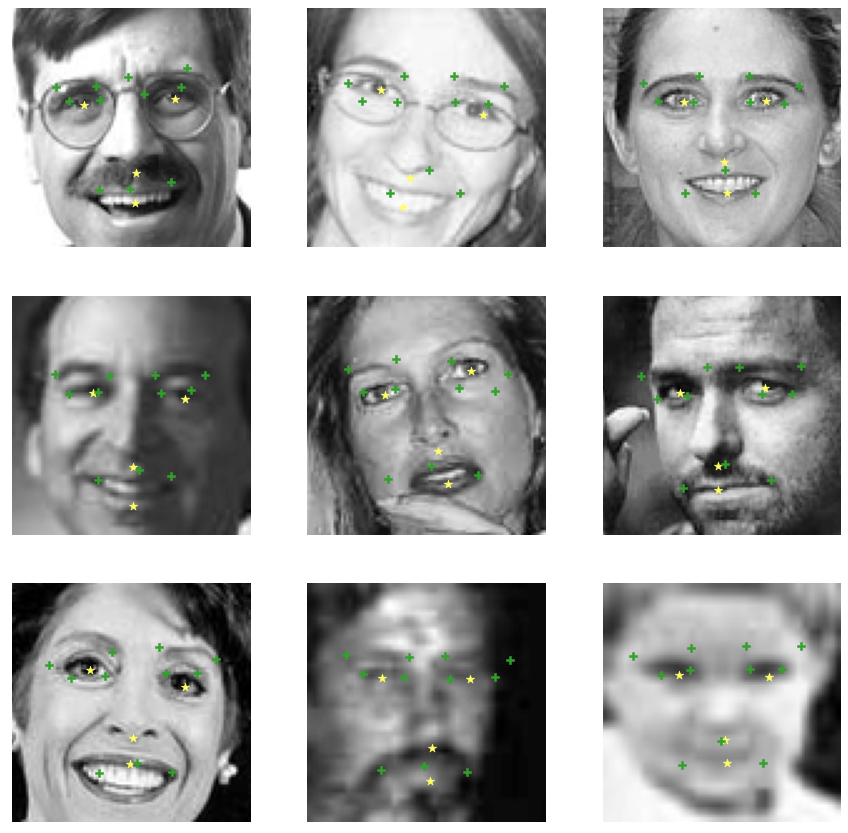

In [0]:
# since we want to visualize how well the missing values were filled, we are not interested in the rows that have all key points
# get a list of indicies for rows that had all values
idx_for_no_missing_values = shuffled_train_df.dropna(how = 'any').index.values.tolist()

# training data indicies goes to 0 to 5999, take out the ones that had all the key points, 
# the remaining are the images missing KP, pick from those using random choice
idx_for_training = list(range(6000))
idx_for_missing_values = list( set(idx_for_training) - set(idx_for_no_missing_values))

# generate 9 indicies to sample from the training data set, call the helper function to plot the pictures
idx = np.random.choice(idx_for_missing_values, size = 9, replace = False).tolist()


plot_images(X_train[idx], Y_train_original[idx], Y_train_ffill[idx])

### 5.2 Fill missing values using median of the column


In [0]:
# approach 2, fillna with median of the column

train_df2 = shuffled_train_df.copy()

# fill na with median, convert into ndarray
train_df2.fillna(train_df2.median(skipna = True), inplace=True)

train_output2 = train_df2.drop('Image', axis = 1).to_numpy() 

# divide output data up into train and dev set
Y_train_median = train_output2[:6000]
Y_dev_median = train_output2[6000:]

with open('/content/drive/My Drive/facial_recognition/resources/train_kp_median.pkl', 'wb') as f: 
    pickle.dump(Y_train_median, f)

with open('/content/drive/My Drive/facial_recognition/resources/dev_kp_median.pkl', 'wb') as f: 
    pickle.dump(Y_dev_median, f)

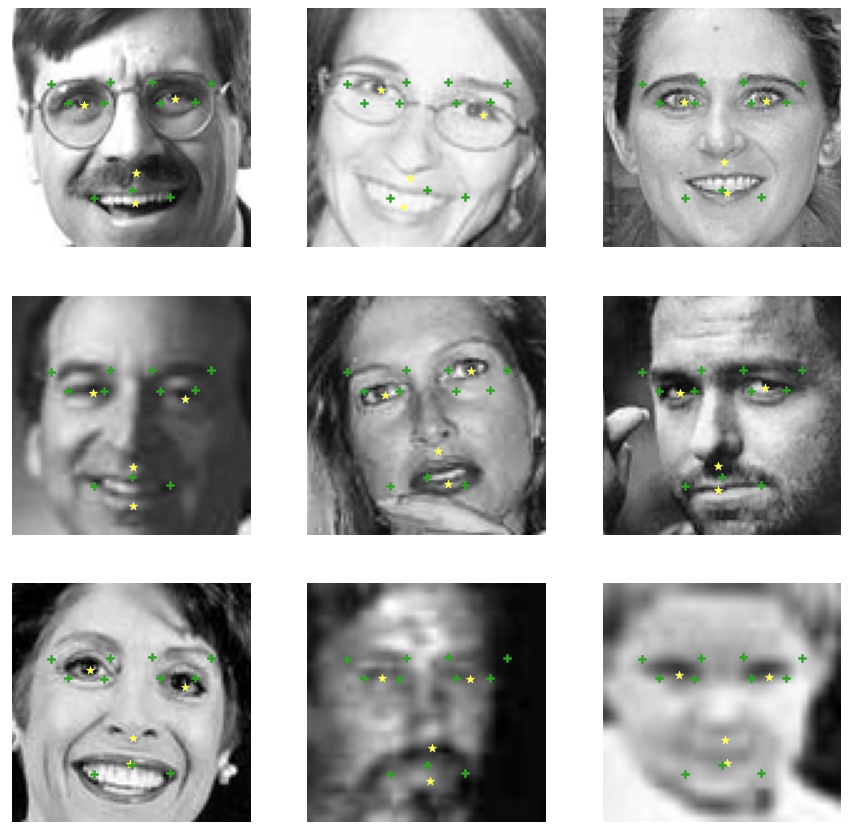

In [0]:
# use the same 9 indices from previous step for comparison
plot_images(X_train[idx], Y_train_original[idx], Y_train_median[idx])

### 5.3 Fill missing values using KNN (K = 9)

In [0]:
# approach 3, fillna using knn

train_df3 = shuffled_train_df.copy()
# delete the image column, use fancy impute knn method to fill the missing output values
del train_df3['Image']

from fancyimpute import KNN
train_df3 = pd.DataFrame(KNN(k=9).fit_transform(train_df3))
train_output3 = train_df3.to_numpy()
Y_train_knn = train_output3[:6000]
Y_dev_knn = train_output3[6000:]

with open('/content/drive/My Drive/facial_recognition/resources/train_kp_knn.pkl', 'wb') as f: 
    pickle.dump(Y_train_knn, f)

with open('/content/drive/My Drive/facial_recognition/resources/dev_kp_knn.pkl', 'wb') as f: 
    pickle.dump(Y_dev_knn, f)

Imputing row 1/7049 with 22 missing, elapsed time: 13.601
Imputing row 101/7049 with 0 missing, elapsed time: 13.690
Imputing row 201/7049 with 0 missing, elapsed time: 13.784
Imputing row 301/7049 with 0 missing, elapsed time: 13.890
Imputing row 401/7049 with 0 missing, elapsed time: 13.989
Imputing row 501/7049 with 22 missing, elapsed time: 14.087
Imputing row 601/7049 with 0 missing, elapsed time: 14.198
Imputing row 701/7049 with 22 missing, elapsed time: 14.304
Imputing row 801/7049 with 22 missing, elapsed time: 14.413
Imputing row 901/7049 with 22 missing, elapsed time: 14.506
Imputing row 1001/7049 with 22 missing, elapsed time: 14.600
Imputing row 1101/7049 with 22 missing, elapsed time: 14.705
Imputing row 1201/7049 with 6 missing, elapsed time: 14.816
Imputing row 1301/7049 with 0 missing, elapsed time: 14.914
Imputing row 1401/7049 with 22 missing, elapsed time: 15.005
Imputing row 1501/7049 with 22 missing, elapsed time: 15.103
Imputing row 1601/7049 with 22 missing, ela

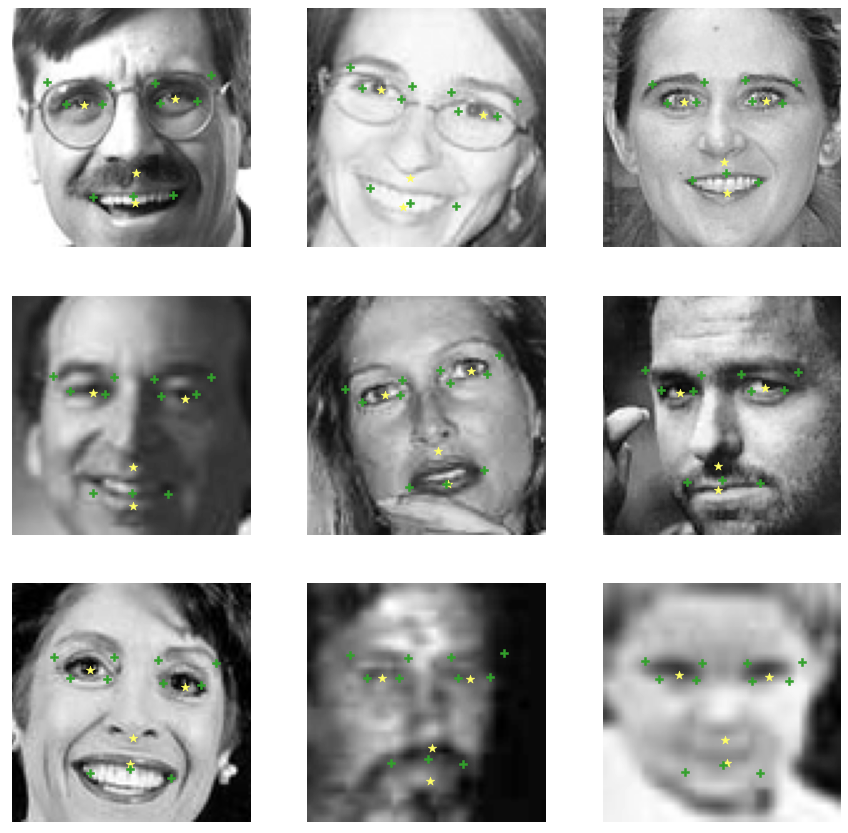

In [0]:
plot_images(X_train[idx], Y_train_original[idx], Y_train_knn[idx])